In [62]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

# Notebook Astromark AI

Questo notebook carica i dati dei ticket, li unisce e li preprocessa (utilizzando spaCy per tokenizzazione, lemmatizzazione e NER), costruisce la pipeline di ML, esegue la grid search, salva/carica il modello e infine fornisce un esempio di utilizzo del ticket service.

In [63]:
import os
import re
import joblib
import pandas as pd
import spacy
from joblib import Parallel, delayed, parallel_backend
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Imposta i percorsi relativi al project root
BASE_DIR = PROJECT_ROOT
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
TRAINED_DIR = os.path.join(BASE_DIR, 'data', 'trained')

TICKET_O3_PATH = os.path.join(DATA_RAW_DIR, 'ticket-o3.csv')
TICKET_GEMINI_PATH = os.path.join(DATA_RAW_DIR, 'ticket-gemini-claude.csv')
PROCESSED_DATA_PATH = os.path.join(PROCESSED_DIR, 'X_processed.csv')

os.makedirs(DATA_RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(TRAINED_DIR, exist_ok=True)

print('[INFO] Percorso per ticket-o3:', TICKET_O3_PATH)
print('[INFO] Percorso per ticket-gemini:', TICKET_GEMINI_PATH)

[INFO] Percorso per ticket-o3: H:\Informatica\astromark-ai\data\raw\ticket-o3.csv
[INFO] Percorso per ticket-gemini: H:\Informatica\astromark-ai\data\raw\ticket-gemini-claude.csv


In [64]:
# Caricamento e unione dei dati
print('[INFO] Caricamento di ticket-o3...')
dataframe_o3 = pd.read_csv(TICKET_O3_PATH, usecols=['titolo', 'messaggio', 'categoria'])
print(f'[INFO] ticket-o3.csv caricato con shape: {dataframe_o3.shape}')

print('[INFO] Caricamento di ticket-gemini-claude...')
dataframe_gc = pd.read_csv(TICKET_GEMINI_PATH, usecols=['titolo', 'messaggio', 'categoria'])
print(f'[INFO] ticket-gemini-claude.csv caricato con shape: {dataframe_gc.shape}')

def merge_dataframes(frame1, frame2):
    print('[INFO] Unione dei dataframe...')
    frame = pd.concat([frame1, frame2])
    
    num_duplicated = frame.duplicated().sum()
    frame.drop_duplicates(inplace=True)
    print(f'[INFO] Eliminate {num_duplicated} righe duplicate:')
    
    frame['titolo_messaggio'] = frame['titolo'] + ' ' + frame['messaggio']
    return frame[['titolo_messaggio', 'categoria']]

merged_df = merge_dataframes(dataframe_o3, dataframe_gc)
X = merged_df['titolo_messaggio']
y = merged_df['categoria']
print(f'[INFO] Dataset unito finale: {merged_df.shape}')

[INFO] Caricamento di ticket-o3...
[INFO] ticket-o3.csv caricato con shape: (4662, 3)
[INFO] Caricamento di ticket-gemini-claude...
[INFO] ticket-gemini-claude.csv caricato con shape: (866, 3)
[INFO] Unione dei dataframe...
[INFO] Eliminate 291 righe duplicate:
[INFO] Dataset unito finale: (5237, 2)



Statistiche descrittive per categoria:
categoria
Segreteria    1088
Didattica     1085
Tecnico       1072
Accesso       1007
Profilo        985
dtype: int64

Percentuali per categoria:
categoria
Segreteria    20.78
Didattica     20.72
Tecnico       20.47
Accesso       19.23
Profilo       18.81
Name: proportion, dtype: float64


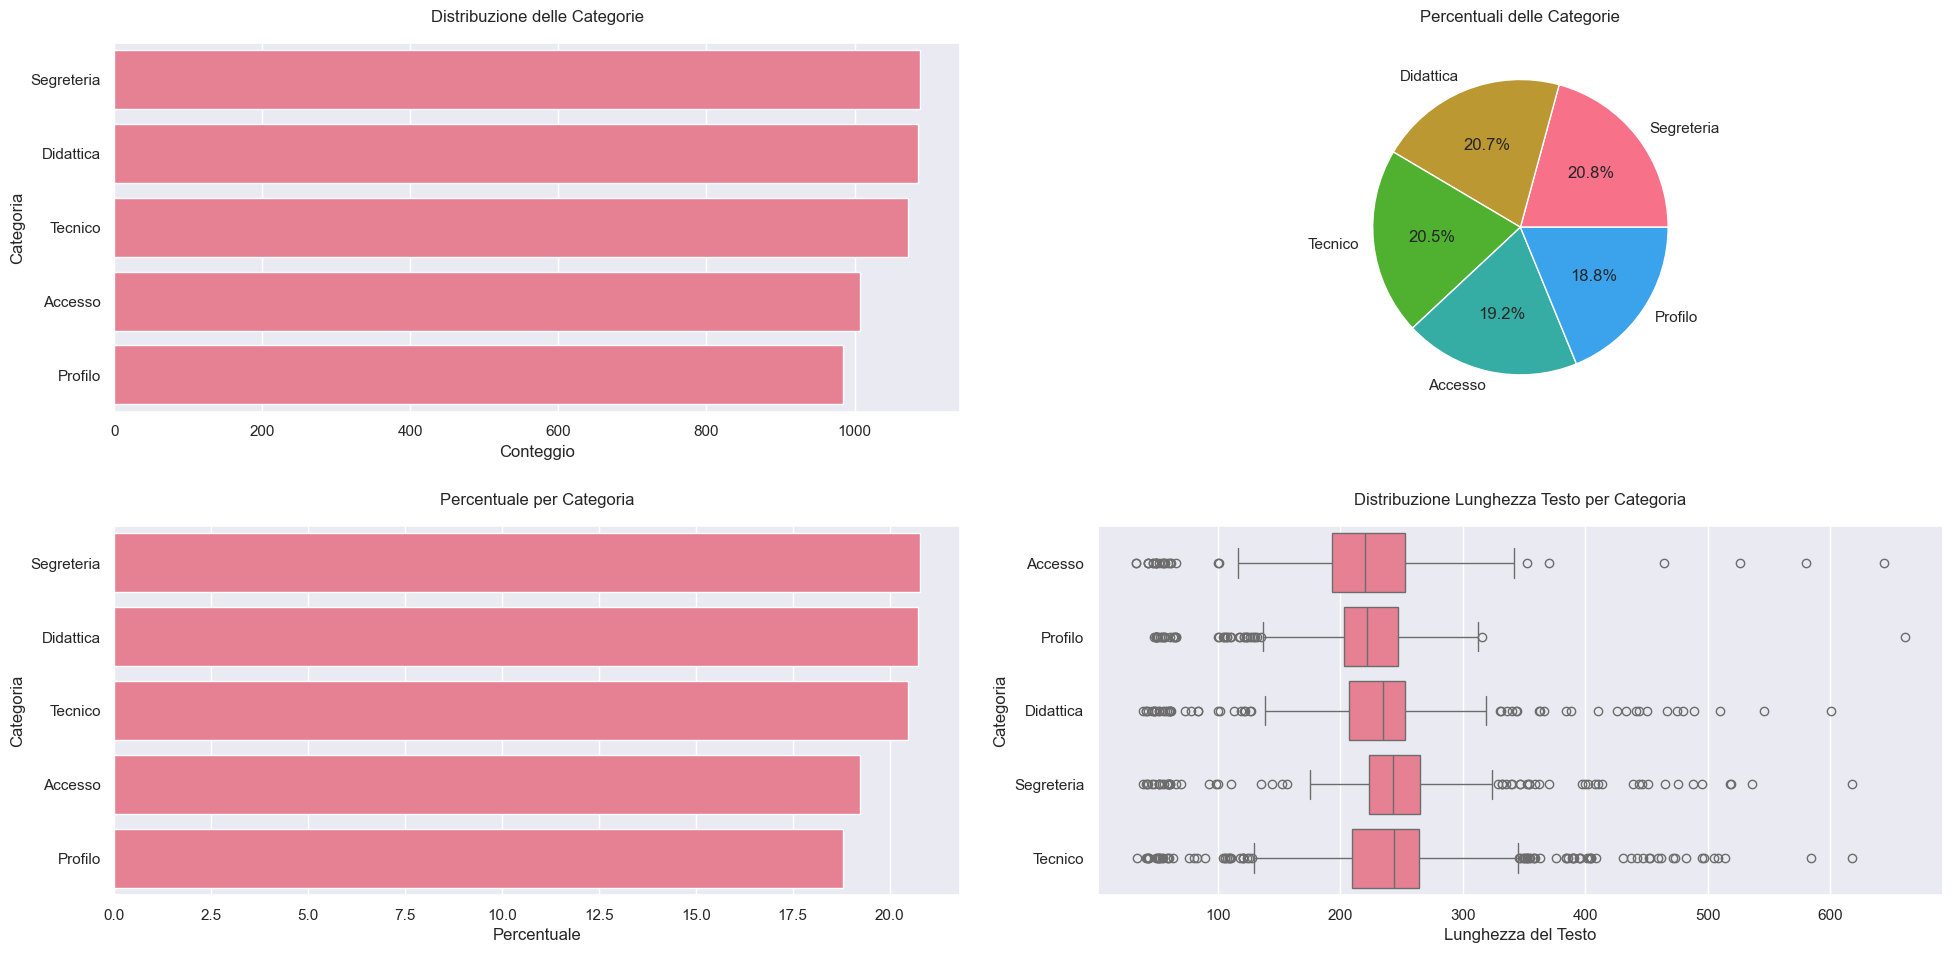

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Impostazioni per una migliore visualizzazione
plt.style.use('default')  # Utilizziamo lo stile default di matplotlib
sns.set_theme()  # Applica il tema base di seaborn
sns.set_palette("husl")

# Creazione di una figura con più sottografici
fig = plt.figure(figsize=(20, 10))

# 1. Grafico a barre della distribuzione delle categorie
plt.subplot(2, 2, 1)
sns.countplot(data=merged_df, y='categoria', order=merged_df['categoria'].value_counts().index)
plt.title('Distribuzione delle Categorie', pad=15)
plt.xlabel('Conteggio')
plt.ylabel('Categoria')

# 2. Grafico a torta delle percentuali
plt.subplot(2, 2, 2)
category_counts = merged_df['categoria'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Percentuali delle Categorie', pad=15)

# 3. Grafico a barre orizzontale con percentuali
plt.subplot(2, 2, 3)
category_percentages = (merged_df['categoria'].value_counts(normalize=True) * 100)
sns.barplot(x=category_percentages.values, y=category_percentages.index)
plt.title('Percentuale per Categoria', pad=15)
plt.xlabel('Percentuale')
plt.ylabel('Categoria')

# 4. Box plot della lunghezza del testo per categoria
plt.subplot(2, 2, 4)
merged_df['text_length'] = merged_df['titolo_messaggio'].str.len()
sns.boxplot(data=merged_df, x='text_length', y='categoria')
plt.title('Distribuzione Lunghezza Testo per Categoria', pad=15)
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Categoria')

# Aggiusta il layout
plt.tight_layout(pad=2.0)

# Mostra statistiche descrittive
print("\nStatistiche descrittive per categoria:")
print(merged_df.groupby('categoria').size().sort_values(ascending=False))
print("\nPercentuali per categoria:")
print(category_percentages.round(2))

# Mostra il plot
plt.show()

In [66]:
# Preprocessing minimo del testo con spaCy
print('[INFO] Caricamento del modello spaCy (it_core_news_sm)...')
nlp = spacy.load('it_core_news_sm')

# Definiamo i saluti da rimuovere
GREETINGS_PATTERNS = [
    r'\bciao\b', r'\bbuongiorno\b', r'\bsalve\b',
    r'\bbuonasera\b', r'\bbuon pomeriggio\b', r'\barrivederci\b',
    r'\bbuonanotte\b', r'\ba presto\b', r'\baddio\b', r'\bsaluti\b'
]

def remove_greetings(text):
    pattern = re.compile('|'.join(GREETINGS_PATTERNS), flags=re.IGNORECASE)
    return pattern.sub('', text)

def minimal_preprocess(text):
    text = text.lower().strip()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # rimozione URL
    text = remove_greetings(text)
    text = re.sub(r'[^\w\s]', ' ', text)  # rimozione punteggiatura
    text = re.sub(r'\d+', '', text)  # rimozione numeri
    text = re.sub(r'\s+', ' ', text)  # normalizzazione spazi
    return text.strip()

def process_text(text):
    cleaned_text = minimal_preprocess(text)
    doc = nlp(cleaned_text)
    tokens = []
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space:
            continue
        lemma = token.lemma_
        if lemma:
            lemma = lemma.strip()
            if lemma:
                tokens.append(lemma)
    for ent in doc.ents:
        tokens.append(f"NER_{ent.label_}")
    return ' '.join(tokens)

def parallel_process_texts(series, n_jobs=-1):
    print('[INFO] Preprocessing in parallelo con backend threading...')
    with parallel_backend('threading', n_jobs=n_jobs):
        processed = Parallel()(delayed(process_text)(text) for text in series)
    return pd.Series(processed, index=series.index)

[INFO] Caricamento del modello spaCy (it_core_news_sm)...


In [67]:
# Carica o processa i dati preprocessati
if os.path.exists(PROCESSED_DATA_PATH):
    print(f"[INFO] Caricamento dei dati preprocessati da '{PROCESSED_DATA_PATH}'...")
    df = pd.read_csv(PROCESSED_DATA_PATH)
    X_processed = df["processed_text"]
else:
    print('[INFO] Dati preprocessati non trovati, inizio preprocessing in parallelo...')
    X_processed = parallel_process_texts(X, n_jobs=-1)
    print('[INFO] Salvataggio dei dati preprocessati in:', PROCESSED_DATA_PATH)
    X_processed_df = pd.DataFrame(X_processed, columns=["processed_text"])
    X_processed_df.to_csv(PROCESSED_DATA_PATH, index=False)
    print('[INFO] Preprocessing completato e memorizzato.')

[INFO] Dati preprocessati non trovati, inizio preprocessing in parallelo...
[INFO] Preprocessing in parallelo con backend threading...
[INFO] Salvataggio dei dati preprocessati in: H:\Informatica\astromark-ai\data\processed\X_processed.csv
[INFO] Preprocessing completato e memorizzato.


In [68]:
from service.pipeline import ClassifierType
from sklearn.pipeline import Pipeline


# Funzioni per costruire la pipeline e la Grid Search
def build_pipeline(classifier_type):
    tfidf = TfidfVectorizer(
        use_idf=True,
        ngram_range=(1, 2),
        max_features=2000,
        norm='l2',
        smooth_idf=True,
        sublinear_tf=True
    )

    if classifier_type == ClassifierType.NAIVE_BAYES:
        classifier = MultinomialNB()
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('clf', classifier)
        ])
        param_grid = {
            'tfidf__min_df': [1, 3],
            'tfidf__max_df': [0.85, 0.90],
            'clf__alpha': [1.0, 1.5, 2.0]
        }
    elif classifier_type == ClassifierType.SVM:
        svd = TruncatedSVD(n_components=50, random_state=42)
        classifier = SVC(probability=True, kernel='linear', random_state=42)
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('svd', svd),
            ('clf', classifier)
        ])
        param_grid = {
            'tfidf__min_df': [1, 3],
            'tfidf__max_df': [0.85, 0.90],
            'svd__n_components': [30, 50],
            'clf__C': [0.1, 0.5, 1.0]
        }
    else:
        raise ValueError("Unsupported classifier type.")
    return pipeline, param_grid

def perform_grid_search(X, y, classifier_type):
    print(f"[INFO] Costruisco la pipeline per {classifier_type.value}...")
    pipeline, param_grid = build_pipeline(classifier_type)
    print(f"[INFO] Avvio Grid Search per {classifier_type.value} con parametri: {param_grid}")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipeline, param_grid, cv=skf, n_jobs=-1, verbose=1)
    grid.fit(X, y)
    print(f"[INFO] Grid Search per {classifier_type.value} completata.")
    print(f"[INFO] Parametri migliori: {grid.best_params_}")
    return grid.best_estimator_


In [69]:
# Funzioni per salvare/caricare il modello
MODEL_PATHS = {
    "naive_bayes": os.path.join(TRAINED_DIR, "trained_model_nb.pkl"),
    "svm": os.path.join(TRAINED_DIR, "trained_model_svm.pkl")
}

def save_model(model, classifier_type):
    path = MODEL_PATHS[classifier_type.value]
    joblib.dump(model, path)
    print(f"[INFO] Modello salvato in {path}.")

def load_model(classifier_type):
    path = MODEL_PATHS[classifier_type.value]
    if os.path.exists(path):
        print(f"[INFO] Caricamento del modello da {path}...")
        return joblib.load(path)
    return None

def get_model(classifier_type):
    """Se esiste un modello preaddestrato, lo carica; altrimenti esegue la grid search e lo salva."""
    model = load_model(classifier_type)
    if model is None:
        print(f"[INFO] Nessun modello salvato per {classifier_type.value}. Avvio training...")
        model = perform_grid_search(X_processed, y, classifier_type)
        save_model(model, classifier_type)
    else:
        print(f"[INFO] Uso il modello salvato per {classifier_type.value}.")
    return model

## Fine della Pipeline

I dati sono stati caricati, preprocessati e il modello (ottenuto tramite Grid Search) è stato caricato o addestrato e salvato nella cartella `../data/trained`.

In [70]:
from service.report_predict import evaluate_model_with_kfold
# Esempio: Funzione per il Ticket Service
def ticket_service(title, message, classifier_type):
    print(evaluate_model_with_kfold(get_model(classifier_type), X_processed, y, save_plots=False))
    print(f"[INFO] Classificatore selezionato: {classifier_type.value}")
    print("[INFO] Recupero del modello finale (lo carico se già esistente)...")
    get_model(classifier_type)
    full_text = f"{title} {message}".strip()
    if not full_text:
        return ["Nessun input fornito"]
    # Importa la funzione predict_category dal modulo report_predict
    from service.report_predict import predict_category
    predictions = predict_category(full_text, classifier_type)
    print("Predizioni:", predictions)
    return predictions

## Esempio di utilizzo con SVM

[INFO] Generating full model report...


[INFO] Caricamento del modello da H:\Informatica\astromark-ai\data\trained\trained_model_svm.pkl...
[INFO] Uso il modello salvato per svm.


[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8914
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.933742  0.945342  0.939506   805.000000
Didattica      0.866365  0.881336  0.873786   868.000000
Profilo        0.955013  0.942893  0.948914   788.000000
Segreteria     0.900498  0.831228  0.864478   871.000000
Tecnico        0.815182  0.864644  0.839185   857.000000
accuracy       0.891382  0.891382  0.891382     0.891382
macro avg      0.894160  0.893089  0.893174  4189.000000
weighted avg   0.892614  0.891382  0.891534  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[761   6  11   8  19]
 [  4 765   1  44  54]
 [ 13   3 743  12  17]
 [  1  58  10 724  78]
 [ 36  51  13  16 741]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.8960
[INFO] Classification Report (Test):
              precision    recall

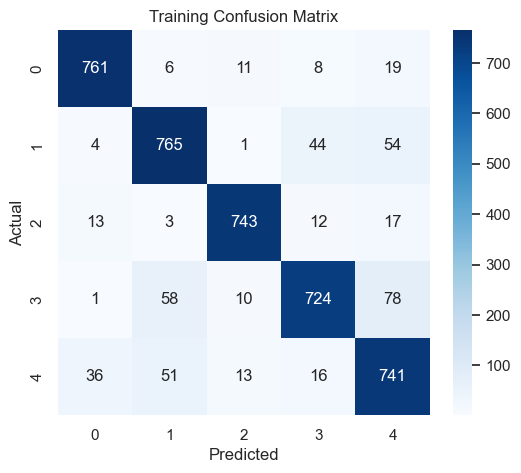

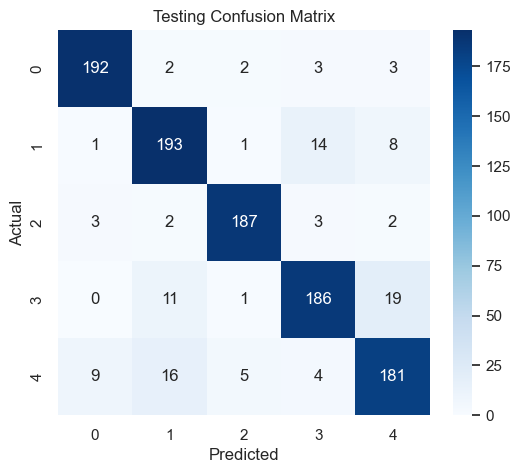

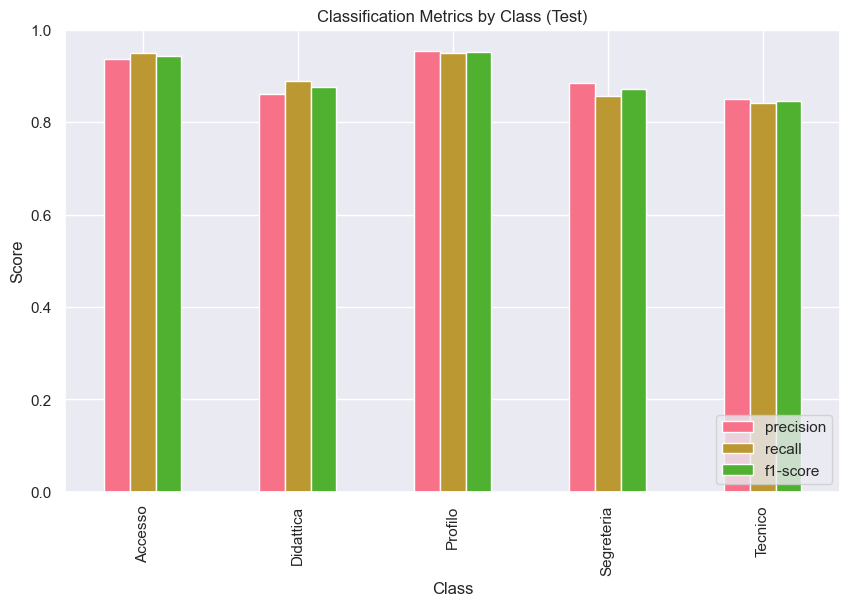

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8871
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.924298  0.940373  0.932266   805.000000
Didattica      0.859570  0.874424  0.866933   868.000000
Profilo        0.952442  0.940355  0.946360   788.000000
Segreteria     0.885404  0.842710  0.863529   871.000000
Tecnico        0.823864  0.845974  0.834773   857.000000
accuracy       0.887085  0.887085  0.887085     0.887085
macro avg      0.889115  0.888767  0.888772  4189.000000
weighted avg   0.887546  0.887085  0.887142  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[757   7  11  11  19]
 [  5 759   2  53  49]
 [ 15   4 741  12  16]
 [  1  56   9 734  71]
 [ 41  57  15  19 725]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9132
[INFO] Classification Report (T

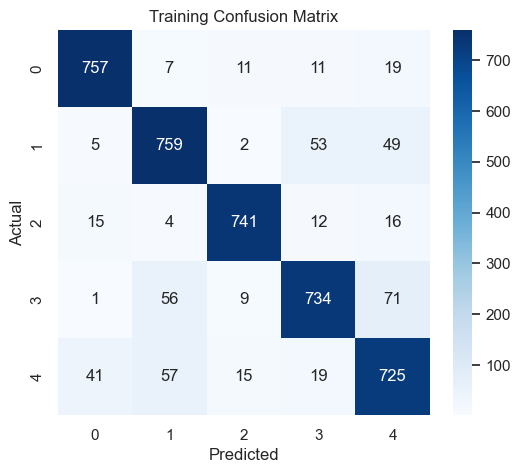

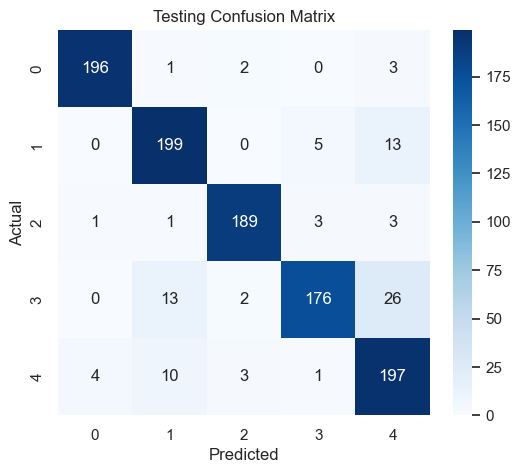

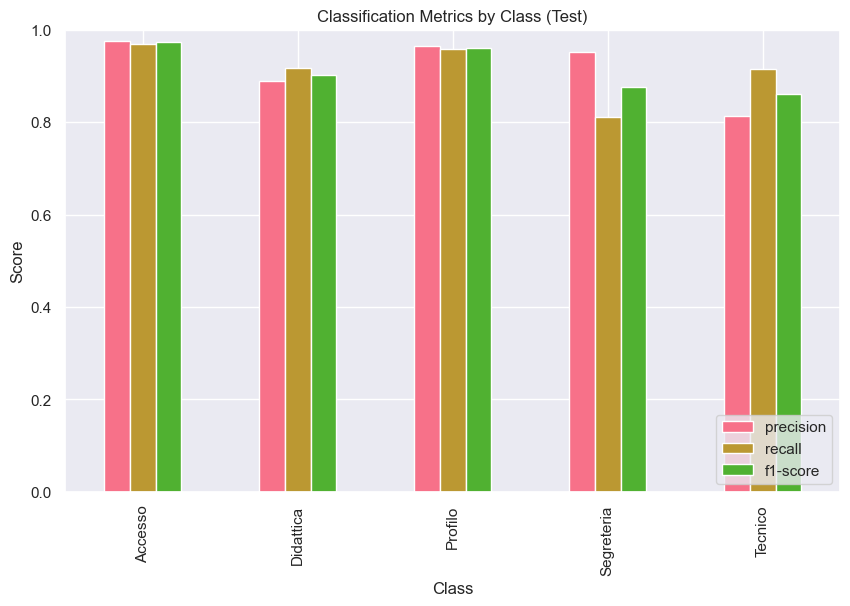

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8952
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.935049  0.946650  0.940814   806.000000
Didattica      0.872460  0.890553  0.881414   868.000000
Profilo        0.955071  0.944162  0.949585   788.000000
Segreteria     0.894737  0.840230  0.866627   870.000000
Tecnico        0.829596  0.862471  0.845714   858.000000
accuracy       0.895227  0.895227  0.895227     0.895227
macro avg      0.897383  0.896813  0.896831  4190.000000
weighted avg   0.895884  0.895227  0.895280  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[763   6  11  10  16]
 [  4 773   1  46  44]
 [ 13   3 744  13  15]
 [  1  53   8 731  77]
 [ 35  51  15  17 740]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.8806
[INFO] Classification Report (T

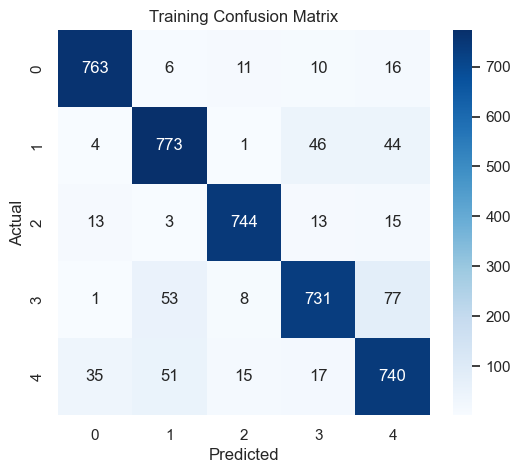

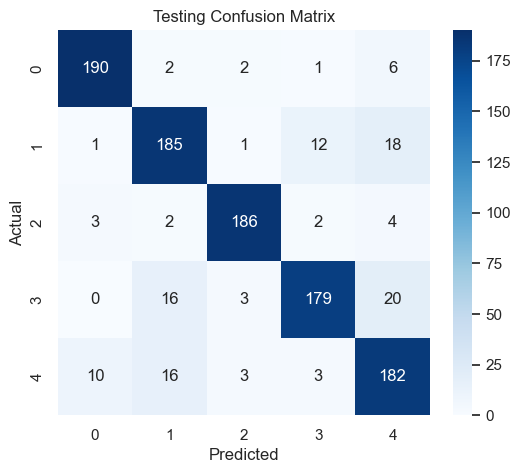

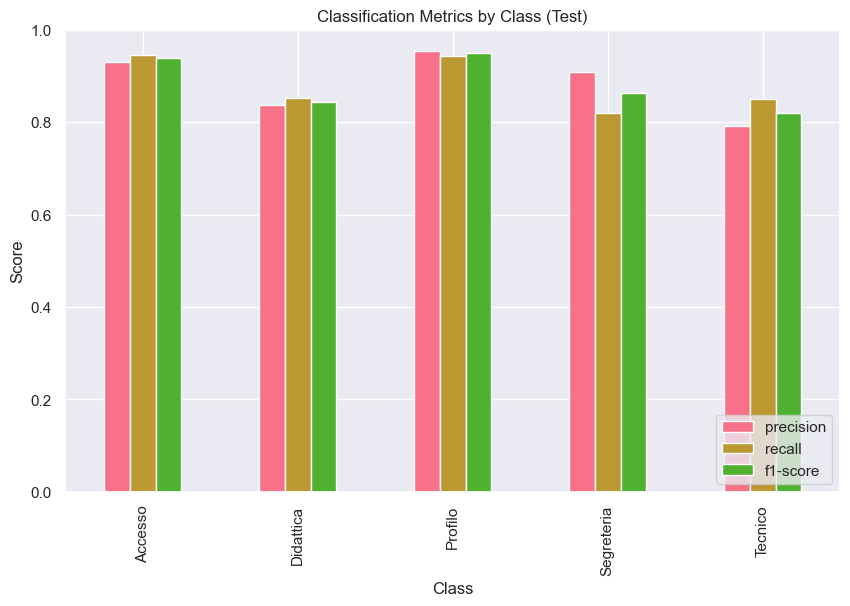

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8933
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.939951  0.951613  0.945746   806.000000
Didattica      0.867196  0.880184  0.873642   868.000000
Profilo        0.962773  0.951777  0.957243   788.000000
Segreteria     0.896894  0.829885  0.862090   870.000000
Tecnico        0.814081  0.862471  0.837578   858.000000
accuracy       0.893317  0.893317  0.893317     0.893317
macro avg      0.896179  0.895186  0.895260  4190.000000
weighted avg   0.894456  0.893317  0.893451  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[767   5   7   7  20]
 [  4 764   2  47  51]
 [ 10   5 750  11  12]
 [  0  54   8 722  86]
 [ 35  53  12  18 740]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.8883
[INFO] Classification Report (T

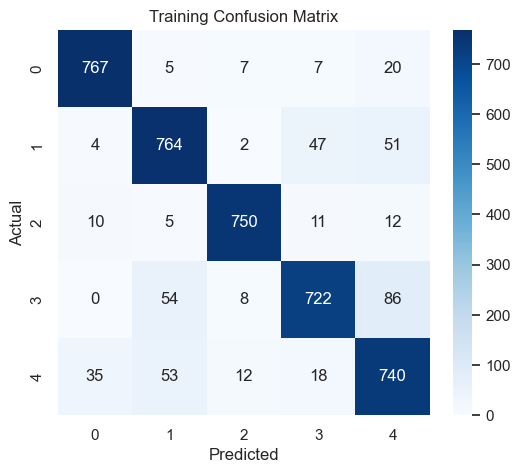

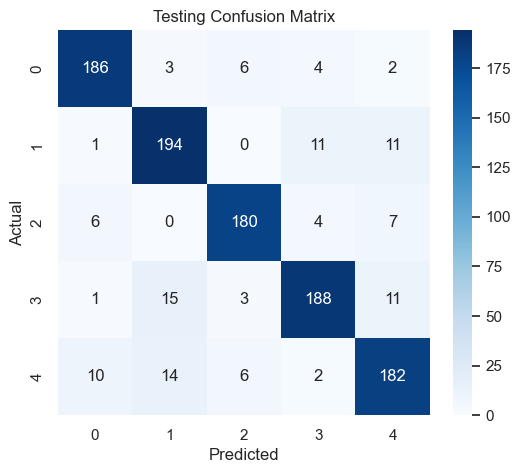

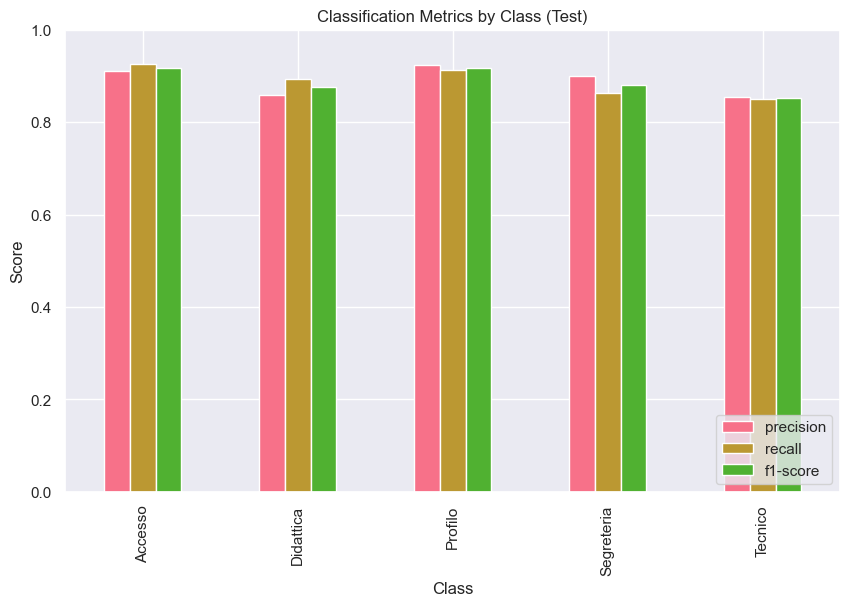

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.8945
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.938575  0.947891  0.943210   806.000000
Didattica      0.861453  0.888249  0.874645   868.000000
Profilo        0.948849  0.941624  0.945223   788.000000
Segreteria     0.910112  0.837931  0.872531   870.000000
Tecnico        0.826281  0.864802  0.845103   858.000000
accuracy       0.894511  0.894511  0.894511     0.894511
macro avg      0.897054  0.896099  0.896142  4190.000000
weighted avg   0.895626  0.894511  0.894619  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[764   8  12   8  14]
 [  3 771   2  42  50]
 [ 13   5 742  12  16]
 [  1  55   9 729  76]
 [ 33  56  17  10 742]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.8835
[INFO] Classification Report (T

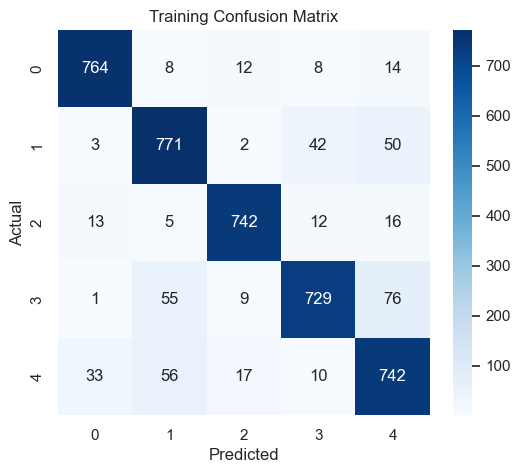

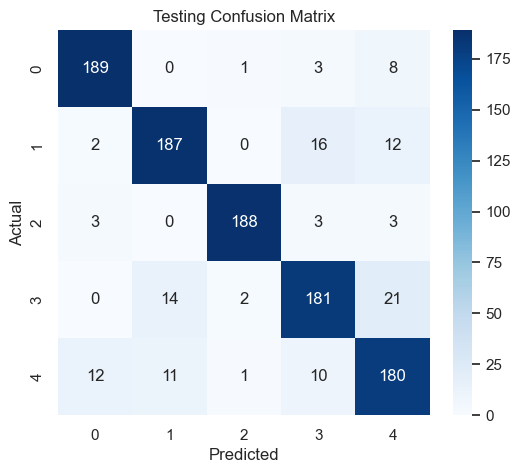

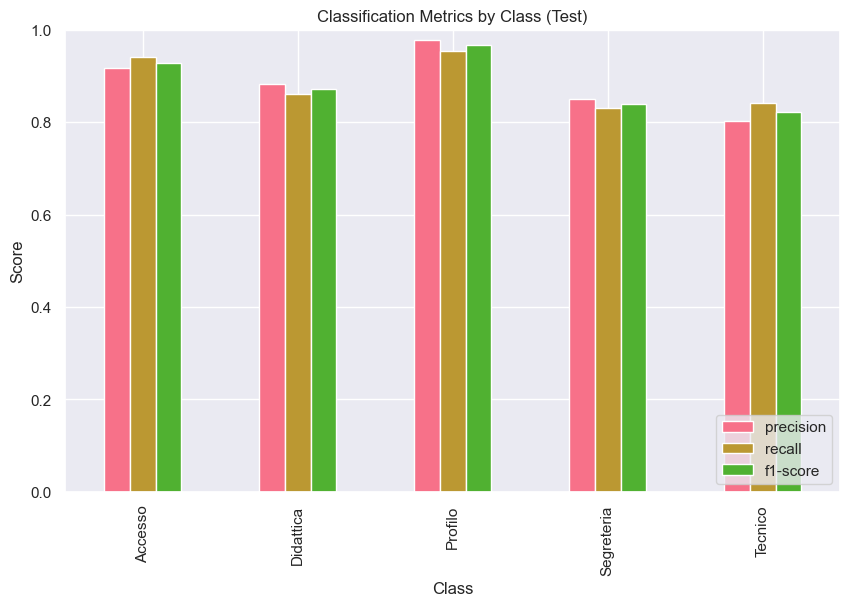

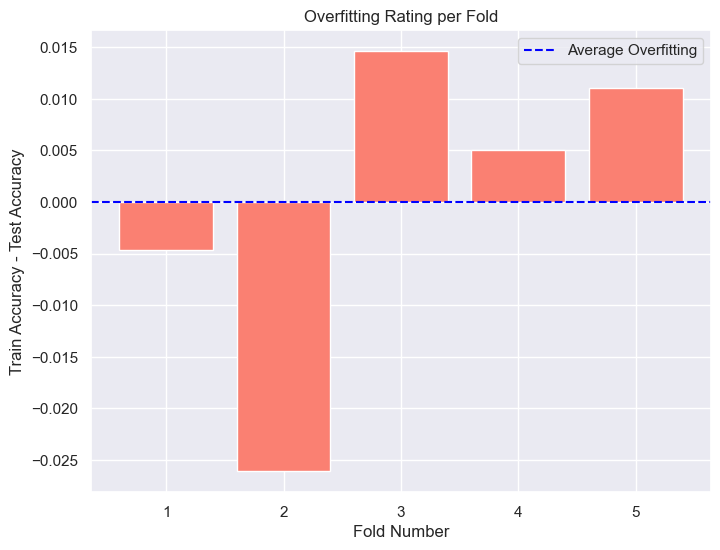

[INFO] Final average evaluation: {'train': {'avg_accuracy': np.float64(0.8923044614517736), 'avg_auc': None, 'avg_confusion_matrix': array([[762.4,   6.4,  10.4,   8.8,  17.6],
       [  4. , 766.4,   1.6,  46.4,  49.6],
       [ 12.8,   4. , 744. ,  12. ,  15.2],
       [  0.8,  55.2,   8.8, 728. ,  77.6],
       [ 36. ,  53.6,  14.4,  16. , 737.6]]), 'avg_classification_report':               precision    recall  f1-score      support
Accesso        0.934323  0.946374  0.940308   805.600000
Didattica      0.865409  0.882949  0.874084   868.000000
Profilo        0.954830  0.944162  0.949465   788.000000
Segreteria     0.897529  0.836397  0.865851   870.400000
Tecnico        0.821801  0.860072  0.840470   857.600000
accuracy       0.892304  0.892304  0.892304     0.892304
macro avg      0.894778  0.893991  0.894036  4189.600000
weighted avg   0.893225  0.892304  0.892405  4189.600000}, 'test': {'avg_accuracy': np.float64(0.8923000648891417), 'avg_auc': None, 'avg_confusion_matrix': arr

{'train': {'avg_accuracy': np.float64(0.8923044614517736), 'avg_auc': None, 'avg_confusion_matrix': array([[762.4,   6.4,  10.4,   8.8,  17.6],
       [  4. , 766.4,   1.6,  46.4,  49.6],
       [ 12.8,   4. , 744. ,  12. ,  15.2],
       [  0.8,  55.2,   8.8, 728. ,  77.6],
       [ 36. ,  53.6,  14.4,  16. , 737.6]]), 'avg_classification_report':               precision    recall  f1-score      support
Accesso        0.934323  0.946374  0.940308   805.600000
Didattica      0.865409  0.882949  0.874084   868.000000
Profilo        0.954830  0.944162  0.949465   788.000000
Segreteria     0.897529  0.836397  0.865851   870.400000
Tecnico        0.821801  0.860072  0.840470   857.600000
accuracy       0.892304  0.892304  0.892304     0.892304
macro avg      0.894778  0.893991  0.894036  4189.600000
weighted avg   0.893225  0.892304  0.892405  4189.600000}, 'test': {'avg_accuracy': np.float64(0.8923000648891417), 'avg_auc': None, 'avg_confusion_matrix': array([[190.6,   1.6,   2.6,   2.2, 

In [71]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
svm_predictions = ticket_service(example_title, example_message, ClassifierType.SVM)

In [72]:
pd.DataFrame(svm_predictions, columns=["Class", "Probability"])

,Class,Probability
0,Tecnico,0.910440
1,Segreteria,0.047449
2,Accesso,0.022335


## Esempio di utilizzo con NAIVE BAYES

[INFO] Nessun modello salvato per naive_bayes. Avvio training...
[INFO] Costruisco la pipeline per naive_bayes...
[INFO] Avvio Grid Search per naive_bayes con parametri: {'tfidf__min_df': [1, 3], 'tfidf__max_df': [0.85, 0.9], 'clf__alpha': [1.0, 1.5, 2.0]}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9203
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.936905  0.977640  0.956839   805.000000
Didattica      0.934368  0.902074  0.917937   868.000000
Profilo        0.934161  0.954315  0.944131   788.000000
Segreteria     0.940224  0.866820  0.902031   871.000000
Tecnico        0.861573  0.907818  0.884091   857.000000
accuracy       0.920267  0.920267  0.920267     0.920267
macro avg      0.921446  0.921733  0.921006  4189.000000
weighted avg   0.921141  0.920267  0.920108  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[787   1   8   2   7]
 [  2 783   4  31  48]
 [ 12   6 752   8  10]
 [  5  33  18 755  60]
 [ 34  15  23   7 778]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9113
[INFO] Classification Report (T

[INFO] Grid Search per naive_bayes completata.
[INFO] Parametri migliori: {'clf__alpha': 1.0, 'tfidf__max_df': 0.85, 'tfidf__min_df': 3}
[INFO] Modello salvato in H:\Informatica\astromark-ai\data\trained\trained_model_nb.pkl.


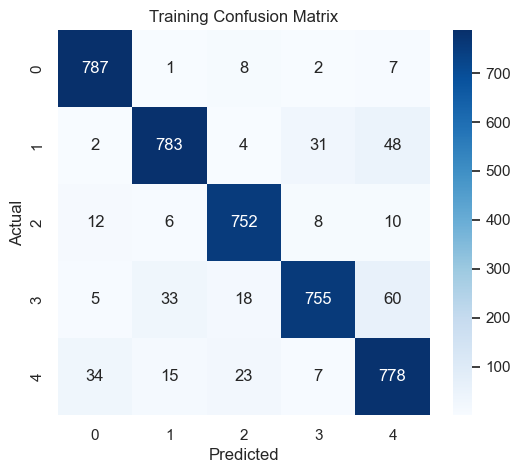

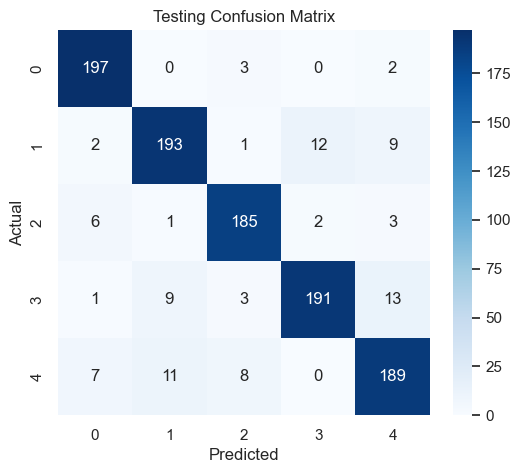

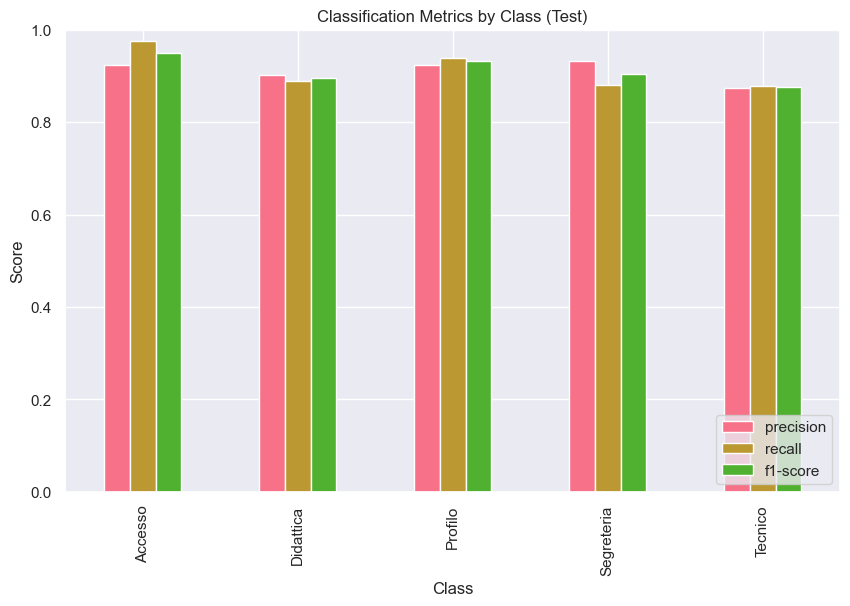

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9172
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.929078  0.976398  0.952150   805.000000
Didattica      0.925355  0.899770  0.912383   868.000000
Profilo        0.931250  0.945431  0.938287   788.000000
Segreteria     0.932763  0.876005  0.903493   871.000000
Tecnico        0.870602  0.894982  0.882624   857.000000
accuracy       0.917164  0.917164  0.917164     0.917164
macro avg      0.917810  0.918517  0.917787  4189.000000
weighted avg   0.917518  0.917164  0.916961  4189.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[786   1  10   1   7]
 [  3 781   5  39  40]
 [ 18   5 745   8  12]
 [  4  35  14 763  55]
 [ 35  22  26   7 767]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9237
[INFO] Classification Report (T

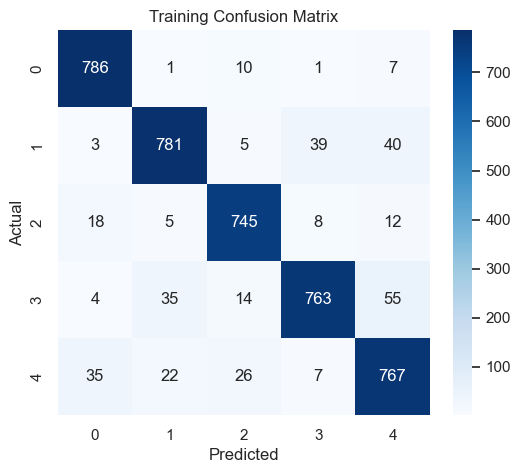

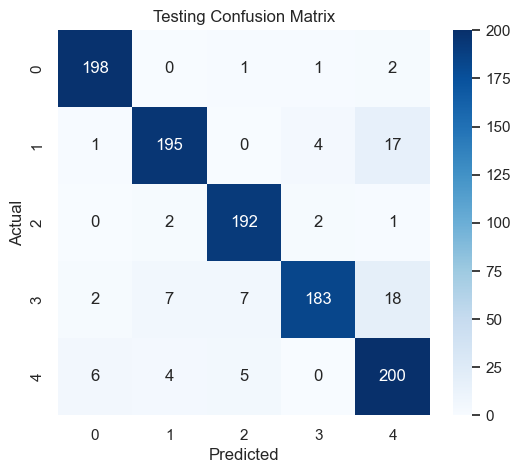

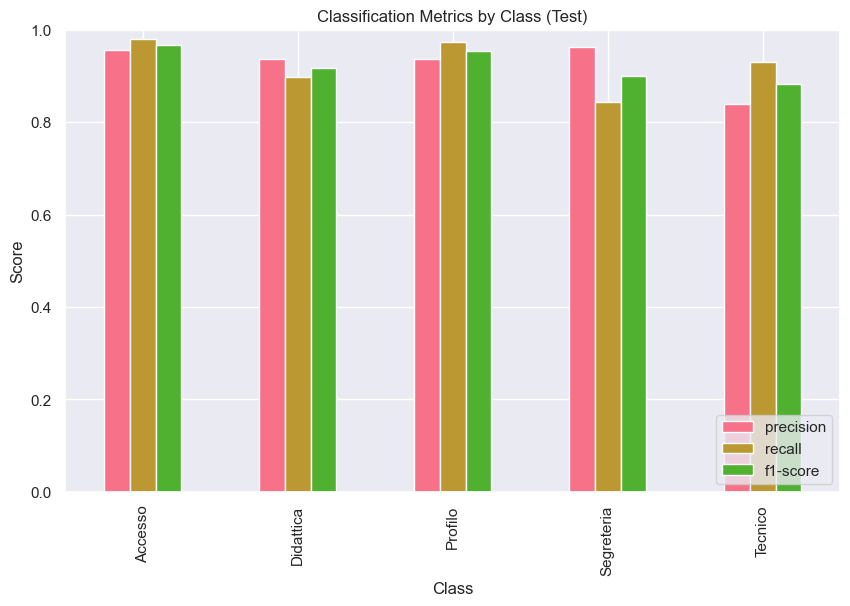

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9200
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.938095  0.977667  0.957473   806.000000
Didattica      0.927059  0.907834  0.917346   868.000000
Profilo        0.933998  0.951777  0.942803   788.000000
Segreteria     0.938903  0.865517  0.900718   870.000000
Tecnico        0.867039  0.904429  0.885339   858.000000
accuracy       0.920048  0.920048  0.920048     0.920048
macro avg      0.921019  0.921445  0.920736  4190.000000
weighted avg   0.920656  0.920048  0.919846  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[788   0   8   2   8]
 [  3 788   2  33  42]
 [ 14   4 750   9  11]
 [  5  35  19 753  58]
 [ 30  23  24   5 776]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9121
[INFO] Classification Report (T

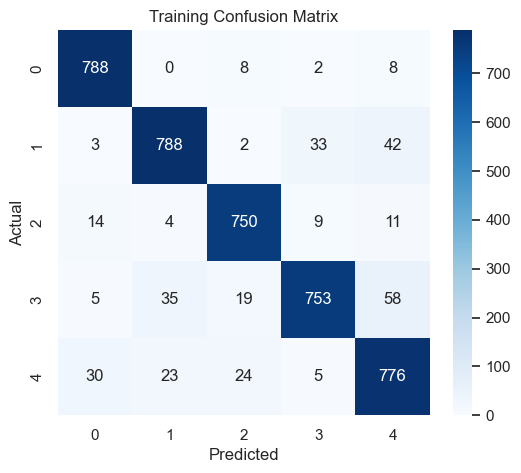

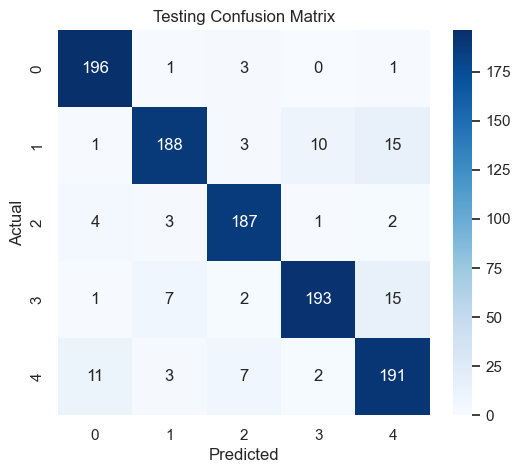

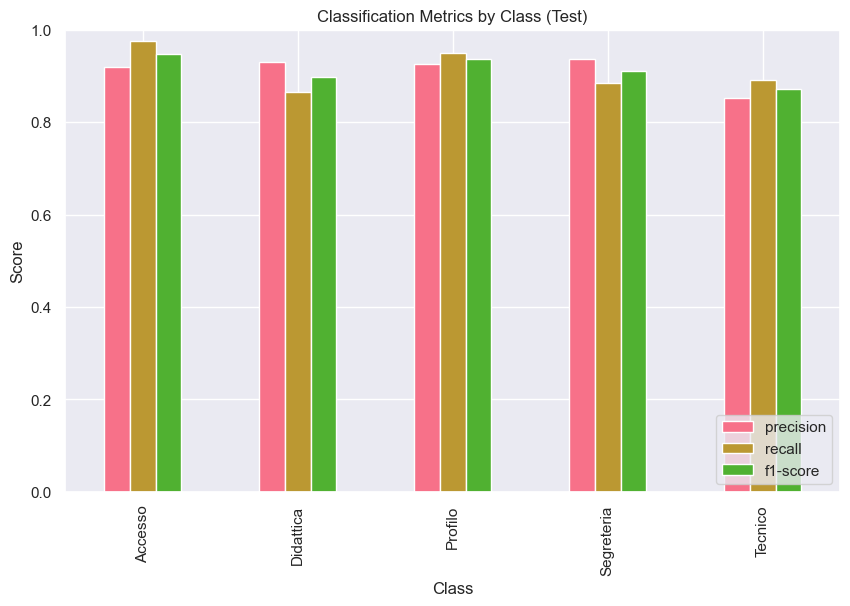

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9169
[INFO] Classification Report (Train):
              precision    recall  f1-score      support
Accesso        0.938095  0.977667  0.957473   806.000000
Didattica      0.922527  0.891705  0.906854   868.000000
Profilo        0.938826  0.954315  0.946507   788.000000
Segreteria     0.936409  0.863218  0.898325   870.000000
Tecnico        0.855727  0.905594  0.879955   858.000000
accuracy       0.916945  0.916945  0.916945     0.916945
macro avg      0.918317  0.918500  0.917823  4190.000000
weighted avg   0.917791  0.916945  0.916770  4190.000000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[788   1   8   2   7]
 [  4 774   4  36  50]
 [ 12   7 752   8   9]
 [  5  35  14 751  65]
 [ 31  22  23   5 777]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9245
[INFO] Classification Report (T

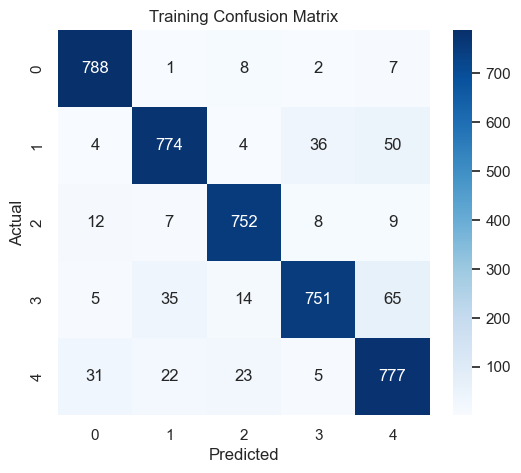

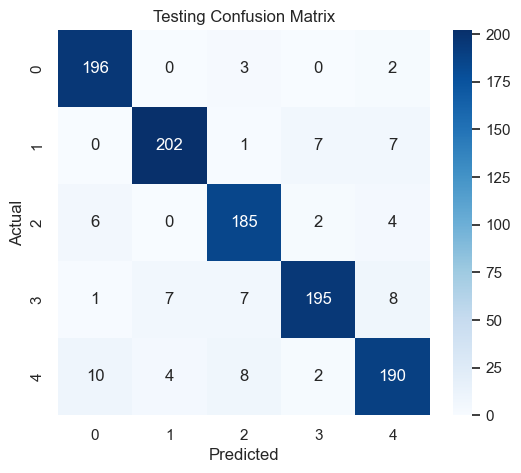

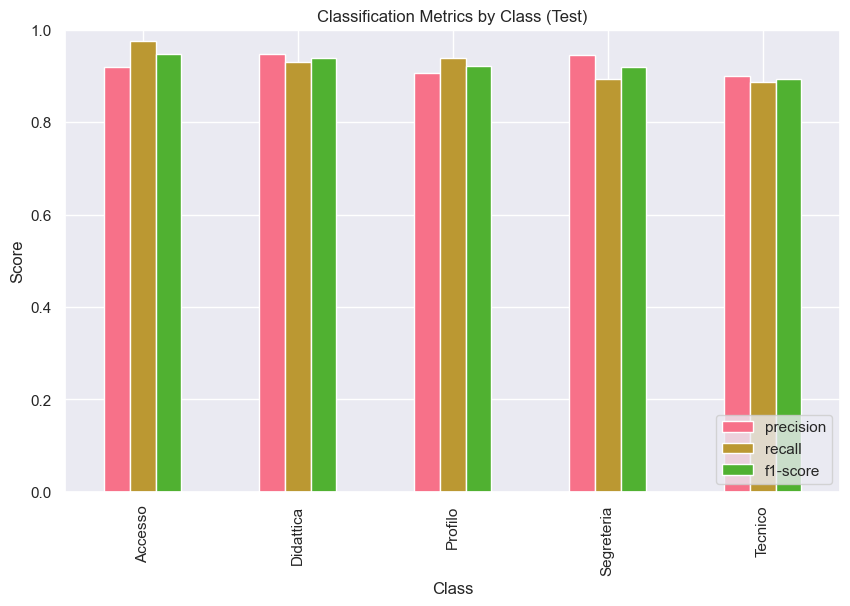

[INFO] Generating full model report...
[INFO] ========== TRAINING METRICS ==========
[INFO] Overall Accuracy: 0.9179
[INFO] Classification Report (Train):
              precision    recall  f1-score    support
Accesso        0.930260  0.976427  0.952785   806.0000
Didattica      0.929510  0.896313  0.912610   868.0000
Profilo        0.923551  0.950508  0.936836   788.0000
Segreteria     0.944238  0.875862  0.908766   870.0000
Tecnico        0.866142  0.897436  0.881511   858.0000
accuracy       0.917900  0.917900  0.917900     0.9179
macro avg      0.918740  0.919309  0.918501  4190.0000
weighted avg   0.918616  0.917900  0.917728  4190.0000
[INFO] Confusion Matrix (Train) - Classes: ['Accesso' 'Didattica' 'Profilo' 'Segreteria' 'Tecnico']
[INFO] 
[[787   1  10   1   7]
 [  4 778   5  33  48]
 [ 16   6 749   7  10]
 [  5  30  19 762  54]
 [ 34  22  28   4 770]]
[INFO] ========== TESTING METRICS ==========
[INFO] Overall Accuracy: 0.9207
[INFO] Classification Report (Test):
            

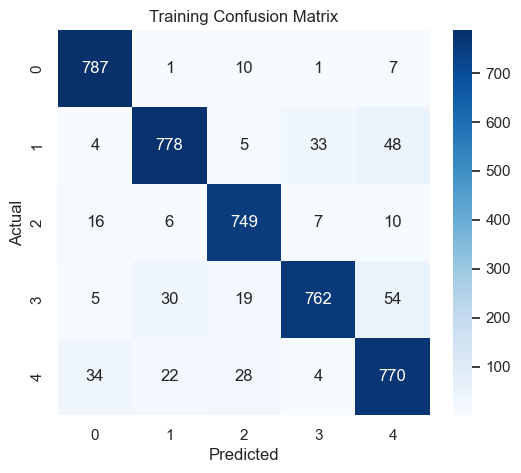

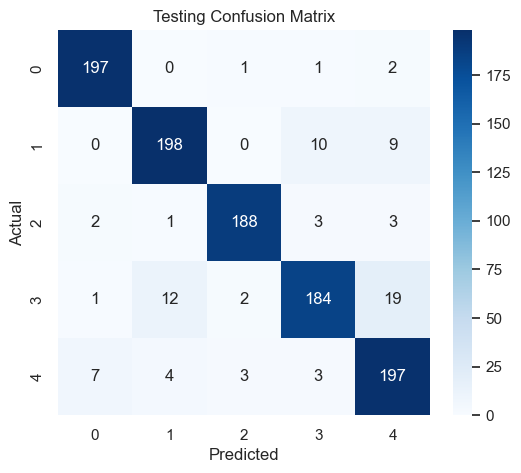

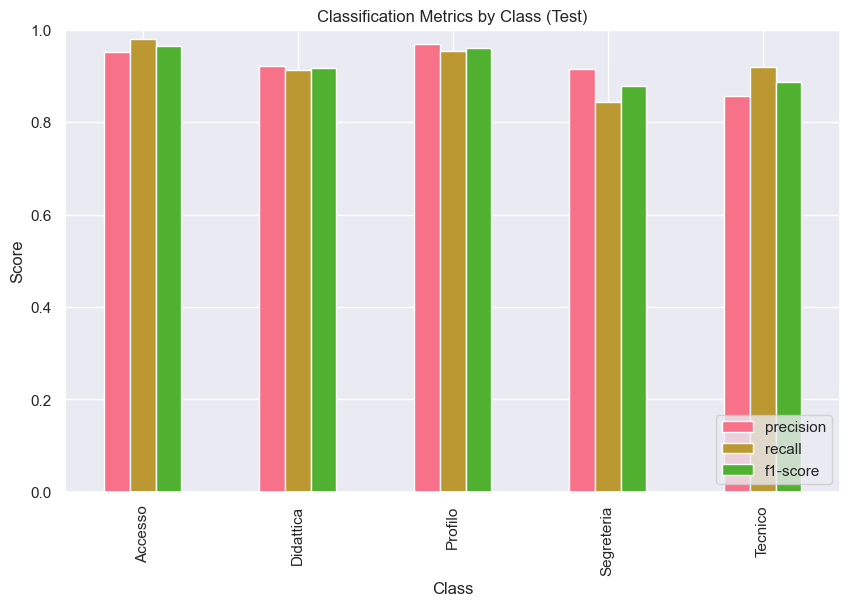

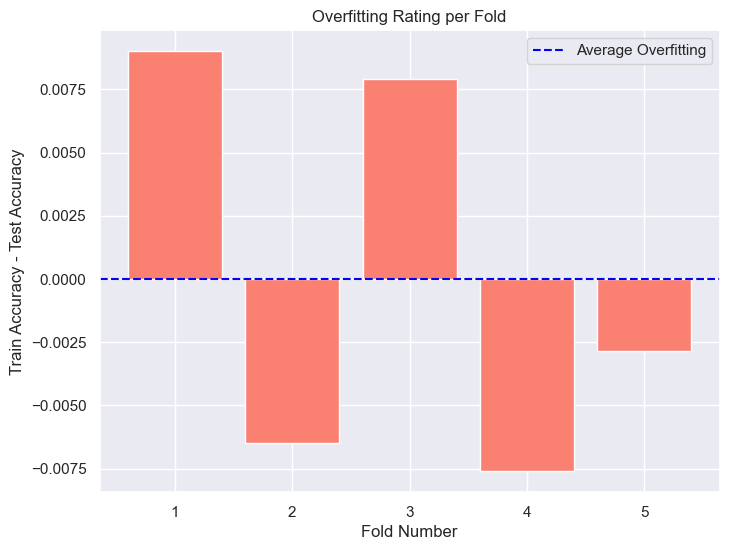

[INFO] Final average evaluation: {'train': {'avg_accuracy': np.float64(0.9184647938600413), 'avg_auc': None, 'avg_confusion_matrix': array([[787.2,   0.8,   8.8,   1.6,   7.2],
       [  3.2, 780.8,   4. ,  34.4,  45.6],
       [ 14.4,   5.6, 749.6,   8. ,  10.4],
       [  4.8,  33.6,  16.8, 756.8,  58.4],
       [ 32.8,  20.8,  24.8,   5.6, 773.6]]), 'avg_classification_report':               precision    recall  f1-score      support
Accesso        0.934487  0.977160  0.955344   805.600000
Didattica      0.927764  0.899539  0.913426   868.000000
Profilo        0.932357  0.951269  0.941713   788.000000
Segreteria     0.938507  0.869484  0.902667   870.400000
Tecnico        0.864216  0.902052  0.882704   857.600000
accuracy       0.918465  0.918465  0.918465     0.918465
macro avg      0.919466  0.919901  0.919171  4189.600000
weighted avg   0.919144  0.918465  0.918283  4189.600000}, 'test': {'avg_accuracy': np.float64(0.918465153072756), 'avg_auc': None, 'avg_confusion_matrix': arra

{'train': {'avg_accuracy': np.float64(0.9184647938600413), 'avg_auc': None, 'avg_confusion_matrix': array([[787.2,   0.8,   8.8,   1.6,   7.2],
       [  3.2, 780.8,   4. ,  34.4,  45.6],
       [ 14.4,   5.6, 749.6,   8. ,  10.4],
       [  4.8,  33.6,  16.8, 756.8,  58.4],
       [ 32.8,  20.8,  24.8,   5.6, 773.6]]), 'avg_classification_report':               precision    recall  f1-score      support
Accesso        0.934487  0.977160  0.955344   805.600000
Didattica      0.927764  0.899539  0.913426   868.000000
Profilo        0.932357  0.951269  0.941713   788.000000
Segreteria     0.938507  0.869484  0.902667   870.400000
Tecnico        0.864216  0.902052  0.882704   857.600000
accuracy       0.918465  0.918465  0.918465     0.918465
macro avg      0.919466  0.919901  0.919171  4189.600000
weighted avg   0.919144  0.918465  0.918283  4189.600000}, 'test': {'avg_accuracy': np.float64(0.918465153072756), 'avg_auc': None, 'avg_confusion_matrix': array([[196.8,   0.2,   2.2,   0.4,  

In [73]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
naive_bayes_predictions = ticket_service(example_title, example_message, ClassifierType.NAIVE_BAYES)

In [74]:
pd.DataFrame(naive_bayes_predictions, columns=["Class", "Probability"])

,Class,Probability
0,Tecnico,0.814730
1,Accesso,0.075047
2,Didattica,0.039581
